Fake News detection 

Using sklearn, I will be building a TfidfVectorizer on the news dataset. Then, I will be initialising a PassiveAggressive Classifier and fit the model. 

The objective of the model is to accurately classify a text as fake news or real news

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


In [25]:
data = pd.read_csv("news.csv")

data.shape
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [26]:
labels = data.label
print(labels.head())
class_counts = labels.value_counts()
print(class_counts)

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


From the above class counts of the data set we can learn that the dataset is balanced. 

In [33]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(encoded_labels[:10])

[0 0 1 0 1 0 0 1 1 1]


In [34]:
x_train,x_test,y_train,y_test = train_test_split(data['text'],
                                                 encoded_labels, test_size=0.2, random_state=7)

Random State is a parameter used to ensure reproducibility of train-test split. 

In [35]:
tfidf_vectoriser = TfidfVectorizer(stop_words='english', max_df=0.7)

tfidf_train = tfidf_vectoriser.fit_transform(x_train)
tfidf_test = tfidf_vectoriser.transform(x_test)

Tfidvectoriser is first initiaslised with stop words from english language and a maximum document frequency of 0.7, terms with higher documnet frequency will be discarded. Stop words are the most common words in a language as such I am filtering them out to reduce noise in data.

I used '.fit' in  tfidf_vectoriser for x_train but not for the x_test. This is so that the vectoriser is fitted based on the leanred parameters from the train set and uses the learned paramaters on the test data. 

By fitting on the training data and using those parameters to transform both the training and test data, we ensure that the test data is evaluated in the same context as the training data. This is crucial for getting an unbiased estimate of the model’s performance.

Fitting on the test data would mean the model has access to information it wouldn’t normally have during deployment, which could lead to overly optimistic performance estimates.

In [43]:
#Initialising classifier
model = PassiveAggressiveClassifier(max_iter=50)
model.fit(tfidf_train,y_train)

#predicitng on test set and calculating accuracy
y_pred = model.predict(tfidf_test)
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.05%


In [46]:
confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[594,  44],
       [ 44, 585]], dtype=int64)

In [47]:
y_pred_prob = model.decision_function(tfidf_test)

In [49]:
# Calculate precision, recall, F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {round(precision*100, 2)}%')
print(f'Recall: {round(recall*100, 2)}%')
print(f'F1 Score: {round(f1*100, 2)}%')

Precision: 93.0%
Recall: 93.0%
F1 Score: 93.0%


In [51]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC Score: {round(roc_auc*100, 2)}%')

ROC-AUC Score: 98.38%


In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

The AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is a performance measurement for classification models, especially binary classifiers. It provides an aggregate measure of performance across all possible classification thresholds. 

High AUC (close to 1): Indicates a good measure of separability. The classifier is good at distinguishing between the positive and negative classes.
AUC close to 0.5: Indicates that the classifier has no discrimination capability to distinguish between positive and negative classes.
Low AUC (close to 0): Indicates a poor model that performs worse than random guessing.

In the context of the ROC curve, a threshold refers to the value at which the decision boundary is set to classify a sample as positive or negative. The decision function or probability output of a classifier is typically a continuous value, and the threshold determines how this continuous value is converted into discrete class labels.

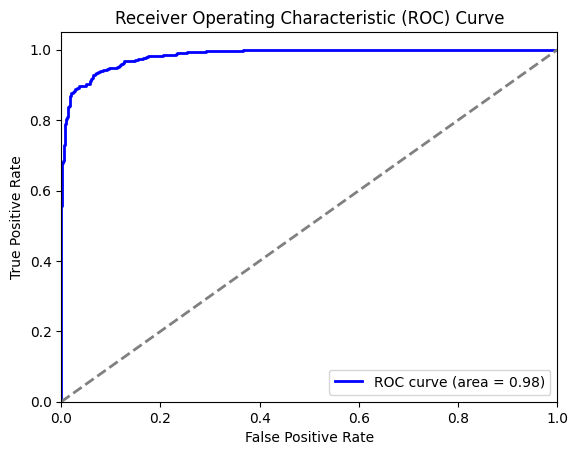

In [56]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [57]:
# Set a specific threshold value
threshold = 0.5

# Apply the threshold to get binary predictions
y_pred_threshold = np.where(y_pred_prob >= threshold, 1, 0)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
conf_matrix = confusion_matrix(y_test, y_pred_threshold)

# Print the results
print(f'Performance at threshold = {threshold}:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

Performance at threshold = 0.5:
Accuracy: 0.92
Precision: 0.98
Recall: 0.86
F1 Score: 0.91
Confusion Matrix:
[[627  11]
 [ 91 538]]


If you want to use a spefic threshold to decide positive and negative. The above method can be used.